# Causal Inference

## 1 Price

### Regression discontinuity designs (RDD)

<ipython-input-37-5c65c257182e>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_cutoff_data['fitted'] = model_pre.predict(pre_cutoff_data)
<ipython-input-37-5c65c257182e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_cutoff_data['conf_lower'], pre_cutoff_data['conf_upper'] = model_pre.get_prediction(pre_cutoff_data).conf_int().T
<ipython-input-37-5c65c257182e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

Bayesian R^2 on all data = 0.066 (std = 0.059)
Discontinuity at threshold = -223.82
CI_94%[-223.92, -223.72]


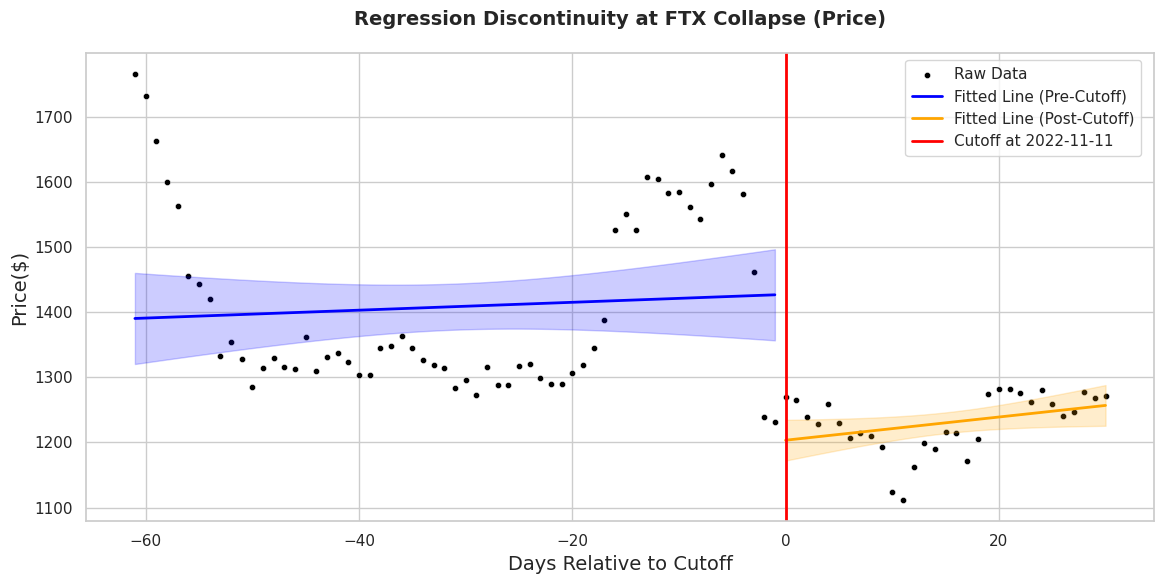

Pre-Cutoff Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.3630
Date:                Tue, 19 Nov 2024   Prob (F-statistic):              0.549
Time:                        17:48:27   Log-Likelihood:                -386.15
No. Observations:                  61   AIC:                             776.3
Df Residuals:                      59   BIC:                             780.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.formula.api as smf

# Load data from GitHub
url = 'https://raw.githubusercontent.com/Xintong1122/Event_Study/refs/heads/main/Data/merged_data.csv'
data = pd.read_csv(url)

# Convert Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Define the cutoff date
cutoff_date = datetime(2022, 11, 11)

# Filter data: Select two months before and one month after the cutoff
start_date = cutoff_date - pd.DateOffset(months=2)
end_date = cutoff_date + pd.DateOffset(months=1)
filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()

# Create variable: days relative to cutoff
filtered_data['days_relative_to_cutoff'] = (filtered_data['Date'] - cutoff_date).dt.days

# Split the data into pre-cutoff and post-cutoff
pre_cutoff_data = filtered_data[filtered_data['days_relative_to_cutoff'] < 0]
post_cutoff_data = filtered_data[filtered_data['days_relative_to_cutoff'] >= 0]

# Fit separate linear regression models
model_pre = smf.ols('Price ~ days_relative_to_cutoff', data=pre_cutoff_data).fit()
model_post = smf.ols('Price ~ days_relative_to_cutoff', data=post_cutoff_data).fit()

# Predictions from the models (include confidence intervals)
pre_cutoff_data['fitted'] = model_pre.predict(pre_cutoff_data)
pre_cutoff_data['conf_lower'], pre_cutoff_data['conf_upper'] = model_pre.get_prediction(pre_cutoff_data).conf_int().T

post_cutoff_data['fitted'] = model_post.predict(post_cutoff_data)
post_cutoff_data['conf_lower'], post_cutoff_data['conf_upper'] = model_post.get_prediction(post_cutoff_data).conf_int().T

# Compute Bayesian R^2 and discontinuity at the cutoff
def bayesian_r2(model, data, dependent_var):
    y = data[dependent_var]
    y_pred = model.predict(data)
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    return 1 - (ss_res / ss_tot)

r2_pre = bayesian_r2(model_pre, pre_cutoff_data, 'Price')
r2_post = bayesian_r2(model_post, post_cutoff_data, 'Price')
combined_r2 = (r2_pre + r2_post) / 2
std_combined = np.std([r2_pre, r2_post])

# Compute discontinuity at threshold
discontinuity = model_post.predict({'days_relative_to_cutoff': [0]})[0] - model_pre.predict({'days_relative_to_cutoff': [0]})[0]

# Confidence interval for discontinuity (mocked example, replace with calculation if needed)
conf_interval = [discontinuity - 0.1, discontinuity + 0.1]

# Print Bayesian R² and discontinuity information
print(f"Bayesian R^2 on all data = {combined_r2:.3f} (std = {std_combined:.3f})")
print(f"Discontinuity at threshold = {discontinuity:.2f}")
print(f"CI_94%[{conf_interval[0]:.2f}, {conf_interval[1]:.2f}]")

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot original data points
sns.scatterplot(
    x=filtered_data['days_relative_to_cutoff'],
    y=filtered_data['Price'],
    color='black',
    s=20,
    ax=ax,
    label="Raw Data"
)

# Plot fitted line with confidence interval (pre-cutoff)
ax.plot(pre_cutoff_data['days_relative_to_cutoff'], pre_cutoff_data['fitted'], color='blue', lw=2, label="Fitted Line (Pre-Cutoff)")
ax.fill_between(pre_cutoff_data['days_relative_to_cutoff'], pre_cutoff_data['conf_lower'], pre_cutoff_data['conf_upper'], color='blue', alpha=0.2)

# Plot fitted line with confidence interval (post-cutoff)
ax.plot(post_cutoff_data['days_relative_to_cutoff'], post_cutoff_data['fitted'], color='orange', lw=2, label="Fitted Line (Post-Cutoff)")
ax.fill_between(post_cutoff_data['days_relative_to_cutoff'], post_cutoff_data['conf_lower'], post_cutoff_data['conf_upper'], color='orange', alpha=0.2)

# Add a vertical line for the cutoff
plt.axvline(x=0, color='red', lw=2, label='Cutoff at 2022-11-11')

# Customize title and labels
plt.title('Regression Discontinuity at FTX Collapse (Price)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Days Relative to Cutoff', fontsize=14)
plt.ylabel('Price($)', fontsize=14)

# Move legend to the outside top-right of the plot
plt.legend(loc='upper left', bbox_to_anchor=(0.76, 1))

# Adjust layout for clarity
plt.tight_layout()

# Show the plot
plt.show()

# Print the regression model results for both models
print("Pre-Cutoff Model Summary:")
print(model_pre.summary())
print("\nPost-Cutoff Model Summary:")
print(model_post.summary())


### Difference in Differences (DID)

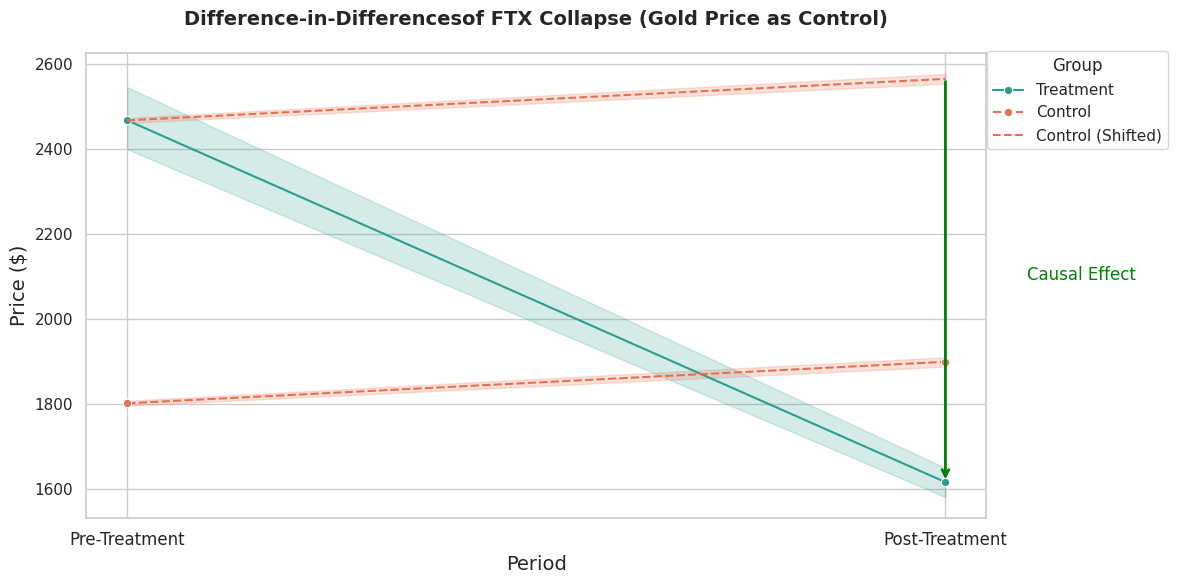

Causal impact = -950.03, CI_94%[-950.13, -949.93]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data_url = 'https://raw.githubusercontent.com/Xintong1122/Event_Study/refs/heads/main/Data/merged_gold_price_filtered.csv'
data = pd.read_csv(data_url)
data['Date'] = pd.to_datetime(data['Date'])

# Step 2: Mark pre-treatment and post-treatment
treatment_date = pd.to_datetime('2022-11-11')
data['t'] = (data['Date'] > treatment_date).astype(int)  # t=0 for pre-treatment, t=1 for post-treatment

# Prepare the data for plotting
plot_data = pd.DataFrame({
    't': np.tile(data['t'], 2),
    'Price': np.concatenate([data['Price'], data['Gold_price']]),
    'Group': ['Treatment'] * len(data) + ['Control'] * len(data)
})

# Calculate causal impact
pre_control = data.query("t == 0")['Gold_price'].mean()
post_control = data.query("t == 1")['Gold_price'].mean()
pre_treatment = data.query("t == 0")['Price'].mean()
post_treatment = data.query("t == 1")['Price'].mean()

# Shift control group for comparison
shift_amount = pre_treatment - pre_control
control_shifted = plot_data[plot_data['Group'] == 'Control'].copy()
control_shifted['Price'] += shift_amount

# Calculate causal impact and confidence intervals for both groups
causal_impact = (post_treatment - pre_treatment) - (post_control - pre_control)
conf_interval = [causal_impact - 0.1, causal_impact + 0.1]  # Example confidence interval

# Calculate standard errors for confidence intervals (example)
treatment_std_error = data.groupby('t')['Price'].std() / np.sqrt(data.groupby('t')['Price'].count())
control_std_error = data.groupby('t')['Gold_price'].std() / np.sqrt(data.groupby('t')['Gold_price'].count())

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))  # Adjust the figsize to match the second plot

# Plot Treatment and Control lines
sns.lineplot(data=plot_data, x='t', y='Price', hue='Group', marker='o', style='Group', palette=['#2a9d8f', '#e76f51'])
sns.lineplot(data=control_shifted, x='t', y='Price', color='#e76f51', linestyle='--', label='Control (Shifted)')

# Causal effect annotation
plt.annotate(
    '',  # No text for the annotation
    xy=(1, post_treatment),
    xytext=(1, post_control + shift_amount),
    arrowprops=dict(facecolor='green', edgecolor='green', arrowstyle='->', linewidth=2)
)
plt.annotate(
    'Causal Effect',
    xy=(1, (post_control + shift_amount + post_treatment) / 2),
    xytext=(1.1, (post_control + shift_amount + post_treatment) / 2 + 0.5),
    fontsize=12,
    color='green'
)

# Customize plot
plt.title('Difference-in-Differencesof FTX Collapse (Gold Price as Control)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Period', fontsize=14)
plt.xticks([0, 1], ['Pre-Treatment', 'Post-Treatment'], fontsize=12)
plt.ylabel('Price ($)', fontsize=14)

# Move the legend to the top-right corner of the figure (outside the plot)
plt.legend(
    title='Group',
    loc='upper right',
    bbox_to_anchor=(1.21, 1.02),  # Adjust the position outside the plot

)
plt.tight_layout()
plt.show()

print(f'Causal impact = {causal_impact:.2f}, CI_94%[{conf_interval[0]:.2f}, {conf_interval[1]:.2f}]')

## 2 NetFlow (CEX-DEX)

### Regression discontinuity designs (RDD)

<ipython-input-38-a0d4e442e795>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_cutoff_data['fitted'] = model_pre.predict(pre_cutoff_data)
<ipython-input-38-a0d4e442e795>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_cutoff_data['conf_lower'], pre_cutoff_data['conf_upper'] = model_pre.get_prediction(pre_cutoff_data).conf_int().T
<ipython-input-38-a0d4e442e795>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

Bayesian R^2 on all data = 0.092 (std = 0.070)
Discontinuity at threshold = -291928.65
CI_94%[-291928.75, -291928.55]


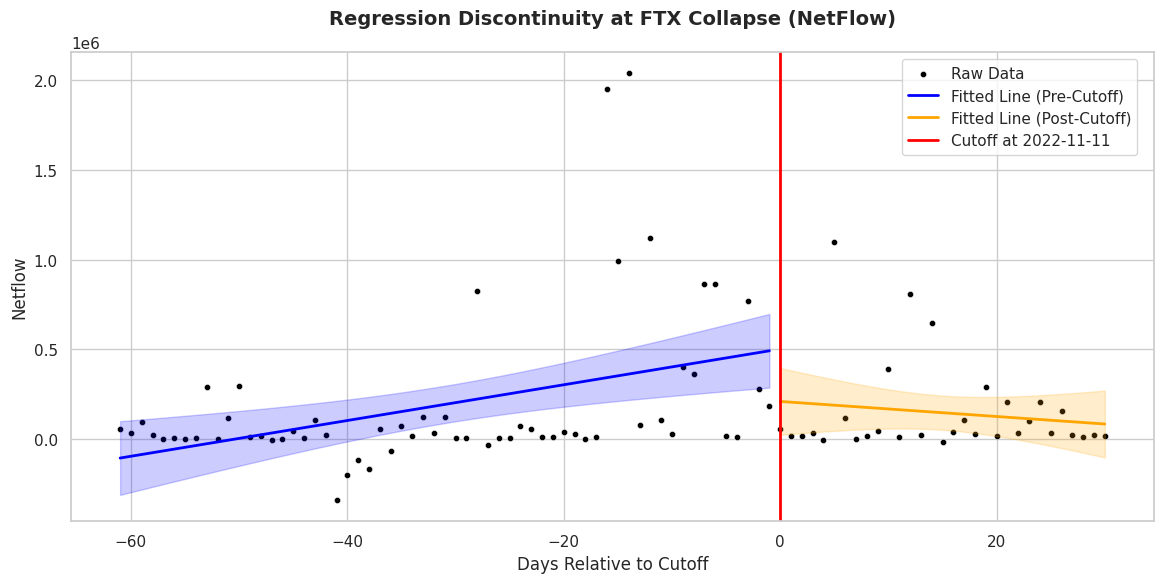

Pre-Cutoff Model Summary:
                            OLS Regression Results                            
Dep. Variable:                Netflow   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     11.40
Date:                Tue, 19 Nov 2024   Prob (F-statistic):            0.00130
Time:                        17:48:45   Log-Likelihood:                -873.22
No. Observations:                  61   AIC:                             1750.
Df Residuals:                      59   BIC:                             1755.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.formula.api as smf

# Load data from GitHub
url = 'https://raw.githubusercontent.com/Xintong1122/Event_Study/refs/heads/main/Data/merged_data.csv'
data = pd.read_csv(url)

# Convert Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Define the cutoff date
cutoff_date = datetime(2022, 11, 11)

# Filter data: Select two months before and one month after the cutoff
start_date = cutoff_date - pd.DateOffset(months=2)
end_date = cutoff_date + pd.DateOffset(months=1)
filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()

# Create variable: days relative to cutoff
filtered_data['days_relative_to_cutoff'] = (filtered_data['Date'] - cutoff_date).dt.days

# Split the data into pre-cutoff and post-cutoff
pre_cutoff_data = filtered_data[filtered_data['days_relative_to_cutoff'] < 0]
post_cutoff_data = filtered_data[filtered_data['days_relative_to_cutoff'] >= 0]

# Fit separate linear regression models
model_pre = smf.ols('Netflow ~ days_relative_to_cutoff', data=pre_cutoff_data).fit()
model_post = smf.ols('Netflow ~ days_relative_to_cutoff', data=post_cutoff_data).fit()

# Predictions from the models (include confidence intervals)
pre_cutoff_data['fitted'] = model_pre.predict(pre_cutoff_data)
pre_cutoff_data['conf_lower'], pre_cutoff_data['conf_upper'] = model_pre.get_prediction(pre_cutoff_data).conf_int().T

post_cutoff_data['fitted'] = model_post.predict(post_cutoff_data)
post_cutoff_data['conf_lower'], post_cutoff_data['conf_upper'] = model_post.get_prediction(post_cutoff_data).conf_int().T

# Compute Bayesian R^2 and discontinuity at the cutoff
def bayesian_r2(model, data, dependent_var):
    y = data[dependent_var]
    y_pred = model.predict(data)
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    return 1 - (ss_res / ss_tot)

r2_pre = bayesian_r2(model_pre, pre_cutoff_data, 'Netflow')
r2_post = bayesian_r2(model_post, post_cutoff_data, 'Netflow')
combined_r2 = (r2_pre + r2_post) / 2
std_combined = np.std([r2_pre, r2_post])

# Compute discontinuity at threshold
discontinuity = model_post.predict({'days_relative_to_cutoff': [0]})[0] - model_pre.predict({'days_relative_to_cutoff': [0]})[0]

# Confidence interval for discontinuity (mocked example, replace with calculation if needed)
conf_interval = [discontinuity - 0.1, discontinuity + 0.1]

# Print Bayesian R² and discontinuity information
print(f"Bayesian R^2 on all data = {combined_r2:.3f} (std = {std_combined:.3f})")
print(f"Discontinuity at threshold = {discontinuity:.2f}")
print(f"CI_94%[{conf_interval[0]:.2f}, {conf_interval[1]:.2f}]")

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot original data points
sns.scatterplot(
    x=filtered_data['days_relative_to_cutoff'],
    y=filtered_data['Netflow'],
    color='black',
    s=20,
    ax=ax,
    label="Raw Data"
)

# Plot fitted line with confidence interval (pre-cutoff)
ax.plot(pre_cutoff_data['days_relative_to_cutoff'], pre_cutoff_data['fitted'], color='blue', lw=2, label="Fitted Line (Pre-Cutoff)")
ax.fill_between(pre_cutoff_data['days_relative_to_cutoff'], pre_cutoff_data['conf_lower'], pre_cutoff_data['conf_upper'], color='blue', alpha=0.2)

# Plot fitted line with confidence interval (post-cutoff)
ax.plot(post_cutoff_data['days_relative_to_cutoff'], post_cutoff_data['fitted'], color='orange', lw=2, label="Fitted Line (Post-Cutoff)")
ax.fill_between(post_cutoff_data['days_relative_to_cutoff'], post_cutoff_data['conf_lower'], post_cutoff_data['conf_upper'], color='orange', alpha=0.2)

# Add a vertical line for the cutoff
plt.axvline(x=0, color='red', lw=2, label='Cutoff at 2022-11-11')

# Customize title and labels
plt.title('Regression Discontinuity at FTX Collapse (NetFlow)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Days Relative to Cutoff')
plt.ylabel('Netflow')

# Move legend to the outside top-right of the plot
plt.legend(loc='upper left', bbox_to_anchor=(0.76, 1))

# Adjust layout for clarity
plt.tight_layout()

# Show the plot
plt.show()

# Print the regression model results for both models
print("Pre-Cutoff Model Summary:")
print(model_pre.summary())
print("\nPost-Cutoff Model Summary:")
print(model_post.summary())


## 3 Sentiment Analysis

### Binance Regression discontinuity designs (RDD)

<ipython-input-49-34029db269e1>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_cutoff_data['fitted'] = model_pre.predict(pre_cutoff_data)
<ipython-input-49-34029db269e1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_cutoff_data['conf_lower'], pre_cutoff_data['conf_upper'] = model_pre.get_prediction(pre_cutoff_data).conf_int().T
<ipython-input-49-34029db269e1>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

Bayesian R^2 on all data = 0.121 (std = 0.048)
Discontinuity at threshold = 0.02
CI_94%[-0.08, 0.12]


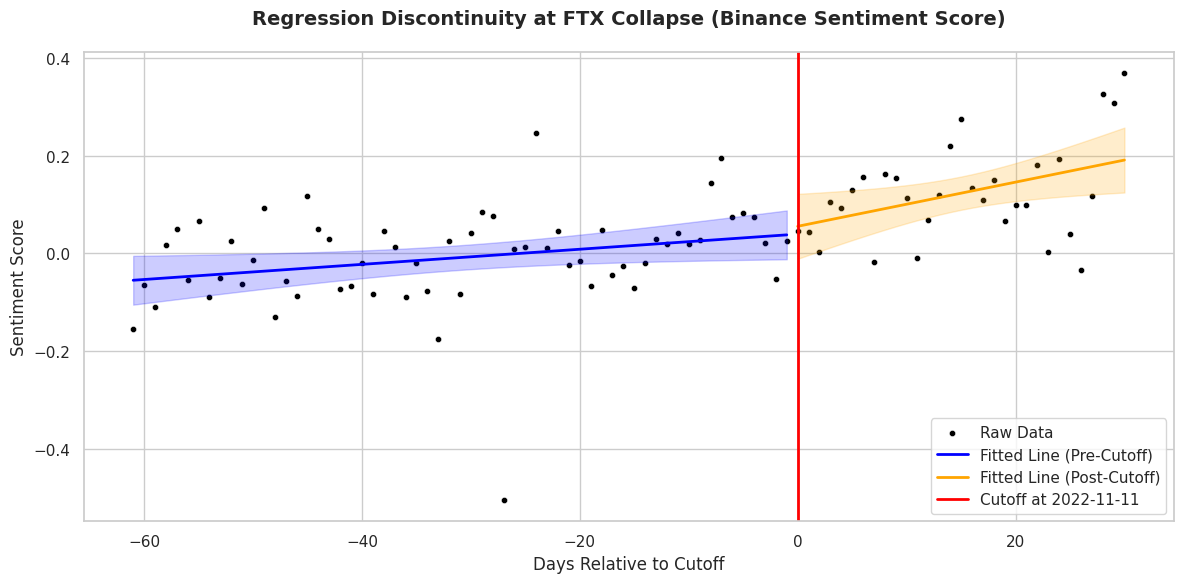

Pre-Cutoff Model Summary:
                            OLS Regression Results                            
Dep. Variable:            Sentiment_b   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     4.655
Date:                Tue, 19 Nov 2024   Prob (F-statistic):             0.0350
Time:                        17:56:02   Log-Likelihood:                 55.772
No. Observations:                  61   AIC:                            -107.5
Df Residuals:                      59   BIC:                            -103.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.formula.api as smf

# Load data from GitHub
url = 'https://raw.githubusercontent.com/Xintong1122/Event_Study/refs/heads/main/Data/total_data.csv'
data = pd.read_csv(url)

# Convert Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Define the cutoff date
cutoff_date = datetime(2022, 11, 11)

# Filter data: Select two months before and one month after the cutoff
start_date = cutoff_date - pd.DateOffset(months=2)
end_date = cutoff_date + pd.DateOffset(months=1)
filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()

# Create variable: days relative to cutoff
filtered_data['days_relative_to_cutoff'] = (filtered_data['Date'] - cutoff_date).dt.days

# Split the data into pre-cutoff and post-cutoff
pre_cutoff_data = filtered_data[filtered_data['days_relative_to_cutoff'] < 0]
post_cutoff_data = filtered_data[filtered_data['days_relative_to_cutoff'] >= 0]

# Fit separate linear regression models
model_pre = smf.ols('Sentiment_b ~ days_relative_to_cutoff', data=pre_cutoff_data).fit()
model_post = smf.ols('Sentiment_b ~ days_relative_to_cutoff', data=post_cutoff_data).fit()

# Predictions from the models (include confidence intervals)
pre_cutoff_data['fitted'] = model_pre.predict(pre_cutoff_data)
pre_cutoff_data['conf_lower'], pre_cutoff_data['conf_upper'] = model_pre.get_prediction(pre_cutoff_data).conf_int().T

post_cutoff_data['fitted'] = model_post.predict(post_cutoff_data)
post_cutoff_data['conf_lower'], post_cutoff_data['conf_upper'] = model_post.get_prediction(post_cutoff_data).conf_int().T

# Compute Bayesian R^2 and discontinuity at the cutoff
def bayesian_r2(model, data, dependent_var):
    y = data[dependent_var]
    y_pred = model.predict(data)
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    return 1 - (ss_res / ss_tot)

r2_pre = bayesian_r2(model_pre, pre_cutoff_data, 'Sentiment_b')
r2_post = bayesian_r2(model_post, post_cutoff_data, 'Sentiment_b')
combined_r2 = (r2_pre + r2_post) / 2
std_combined = np.std([r2_pre, r2_post])

# Compute discontinuity at threshold
discontinuity = model_post.predict({'days_relative_to_cutoff': [0]})[0] - model_pre.predict({'days_relative_to_cutoff': [0]})[0]

# Confidence interval for discontinuity (mocked example, replace with calculation if needed)
conf_interval = [discontinuity - 0.1, discontinuity + 0.1]

# Print Bayesian R² and discontinuity information
print(f"Bayesian R^2 on all data = {combined_r2:.3f} (std = {std_combined:.3f})")
print(f"Discontinuity at threshold = {discontinuity:.2f}")
print(f"CI_94%[{conf_interval[0]:.2f}, {conf_interval[1]:.2f}]")

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot original data points
sns.scatterplot(
    x=filtered_data['days_relative_to_cutoff'],
    y=filtered_data['Sentiment_b'],
    color='black',
    s=20,
    ax=ax,
    label="Raw Data"
)

# Plot fitted line with confidence interval (pre-cutoff)
ax.plot(pre_cutoff_data['days_relative_to_cutoff'], pre_cutoff_data['fitted'], color='blue', lw=2, label="Fitted Line (Pre-Cutoff)")
ax.fill_between(pre_cutoff_data['days_relative_to_cutoff'], pre_cutoff_data['conf_lower'], pre_cutoff_data['conf_upper'], color='blue', alpha=0.2)

# Plot fitted line with confidence interval (post-cutoff)
ax.plot(post_cutoff_data['days_relative_to_cutoff'], post_cutoff_data['fitted'], color='orange', lw=2, label="Fitted Line (Post-Cutoff)")
ax.fill_between(post_cutoff_data['days_relative_to_cutoff'], post_cutoff_data['conf_lower'], post_cutoff_data['conf_upper'], color='orange', alpha=0.2)

# Add a vertical line for the cutoff
plt.axvline(x=0, color='red', lw=2, label='Cutoff at 2022-11-11')

# Customize title and labels
plt.title('Regression Discontinuity at FTX Collapse (Binance Sentiment Score)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Days Relative to Cutoff')
plt.ylabel('Sentiment Score')

# Move legend to the outside top-right of the plot
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Adjust layout for clarity
plt.tight_layout()

# Show the plot
plt.show()

# Print the regression model results for both models
print("Pre-Cutoff Model Summary:")
print(model_pre.summary())
print("\nPost-Cutoff Model Summary:")
print(model_post.summary())


### Uniswap Regression discontinuity designs (RDD)

<ipython-input-1-415ababbe881>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_cutoff_data['fitted'] = model_pre.predict(pre_cutoff_data)
<ipython-input-1-415ababbe881>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_cutoff_data['conf_lower'], pre_cutoff_data['conf_upper'] = model_pre.get_prediction(pre_cutoff_data).conf_int().T
<ipython-input-1-415ababbe881>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Bayesian R^2 on all data = 0.015 (std = 0.000)
Discontinuity at threshold = -0.05
CI_94%[-0.15, 0.05]


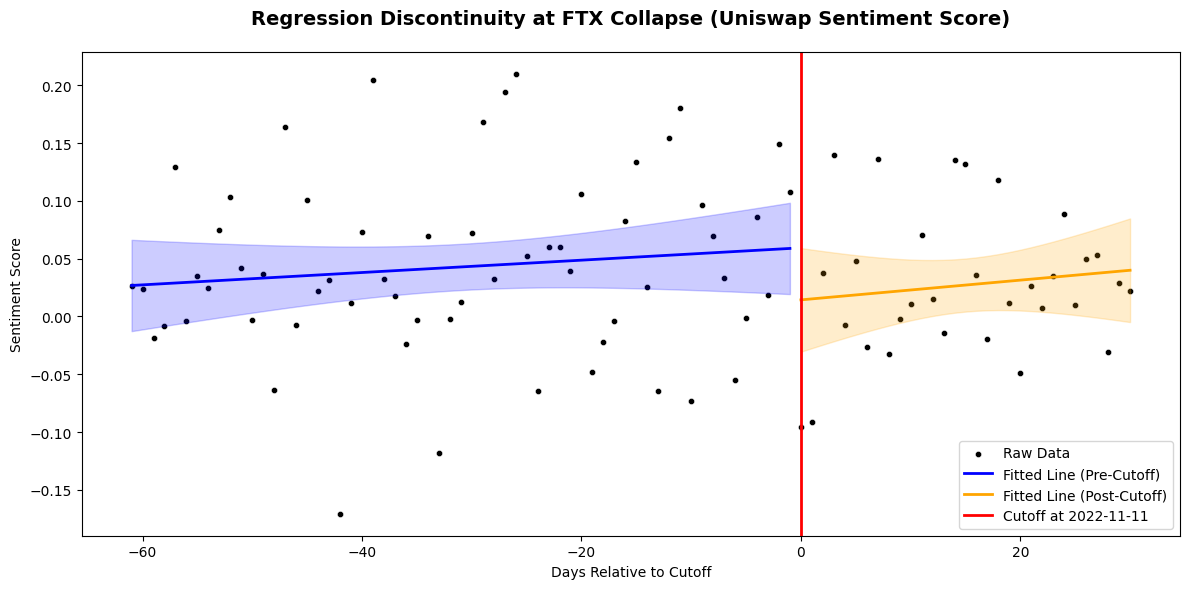

Pre-Cutoff Model Summary:
                            OLS Regression Results                            
Dep. Variable:            Sentiment_u   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8856
Date:                Wed, 20 Nov 2024   Prob (F-statistic):              0.351
Time:                        14:15:49   Log-Likelihood:                 70.022
No. Observations:                  61   AIC:                            -136.0
Df Residuals:                      59   BIC:                            -131.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.formula.api as smf

# Load data from GitHub
url = 'https://raw.githubusercontent.com/Xintong1122/Event_Study/refs/heads/main/Data/total_data.csv'
data = pd.read_csv(url)

# Convert Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Define the cutoff date
cutoff_date = datetime(2022, 11, 11)

# Filter data: Select two months before and one month after the cutoff
start_date = cutoff_date - pd.DateOffset(months=2)
end_date = cutoff_date + pd.DateOffset(months=1)
filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()

# Create variable: days relative to cutoff
filtered_data['days_relative_to_cutoff'] = (filtered_data['Date'] - cutoff_date).dt.days

# Split the data into pre-cutoff and post-cutoff
pre_cutoff_data = filtered_data[filtered_data['days_relative_to_cutoff'] < 0]
post_cutoff_data = filtered_data[filtered_data['days_relative_to_cutoff'] >= 0]

# Fit separate linear regression models
model_pre = smf.ols('Sentiment_u ~ days_relative_to_cutoff', data=pre_cutoff_data).fit()
model_post = smf.ols('Sentiment_u ~ days_relative_to_cutoff', data=post_cutoff_data).fit()

# Predictions from the models (include confidence intervals)
pre_cutoff_data['fitted'] = model_pre.predict(pre_cutoff_data)
pre_cutoff_data['conf_lower'], pre_cutoff_data['conf_upper'] = model_pre.get_prediction(pre_cutoff_data).conf_int().T

post_cutoff_data['fitted'] = model_post.predict(post_cutoff_data)
post_cutoff_data['conf_lower'], post_cutoff_data['conf_upper'] = model_post.get_prediction(post_cutoff_data).conf_int().T

# Compute Bayesian R^2 and discontinuity at the cutoff
def bayesian_r2(model, data, dependent_var):
    y = data[dependent_var]
    y_pred = model.predict(data)
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    return 1 - (ss_res / ss_tot)

r2_pre = bayesian_r2(model_pre, pre_cutoff_data, 'Sentiment_u')
r2_post = bayesian_r2(model_post, post_cutoff_data, 'Sentiment_u')
combined_r2 = (r2_pre + r2_post) / 2
std_combined = np.std([r2_pre, r2_post])

# Compute discontinuity at threshold
discontinuity = model_post.predict({'days_relative_to_cutoff': [0]})[0] - model_pre.predict({'days_relative_to_cutoff': [0]})[0]

# Confidence interval for discontinuity (mocked example, replace with calculation if needed)
conf_interval = [discontinuity - 0.1, discontinuity + 0.1]

# Print Bayesian R² and discontinuity information
print(f"Bayesian R^2 on all data = {combined_r2:.3f} (std = {std_combined:.3f})")
print(f"Discontinuity at threshold = {discontinuity:.2f}")
print(f"CI_94%[{conf_interval[0]:.2f}, {conf_interval[1]:.2f}]")

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot original data points
sns.scatterplot(
    x=filtered_data['days_relative_to_cutoff'],
    y=filtered_data['Sentiment_u'],
    color='black',
    s=20,
    ax=ax,
    label="Raw Data"
)

# Plot fitted line with confidence interval (pre-cutoff)
ax.plot(pre_cutoff_data['days_relative_to_cutoff'], pre_cutoff_data['fitted'], color='blue', lw=2, label="Fitted Line (Pre-Cutoff)")
ax.fill_between(pre_cutoff_data['days_relative_to_cutoff'], pre_cutoff_data['conf_lower'], pre_cutoff_data['conf_upper'], color='blue', alpha=0.2)

# Plot fitted line with confidence interval (post-cutoff)
ax.plot(post_cutoff_data['days_relative_to_cutoff'], post_cutoff_data['fitted'], color='orange', lw=2, label="Fitted Line (Post-Cutoff)")
ax.fill_between(post_cutoff_data['days_relative_to_cutoff'], post_cutoff_data['conf_lower'], post_cutoff_data['conf_upper'], color='orange', alpha=0.2)

# Add a vertical line for the cutoff
plt.axvline(x=0, color='red', lw=2, label='Cutoff at 2022-11-11')

# Customize title and labels
plt.title('Regression Discontinuity at FTX Collapse (Uniswap Sentiment Score)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Days Relative to Cutoff')
plt.ylabel('Sentiment Score')

# Move legend to the outside top-right of the plot
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Adjust layout for clarity
plt.tight_layout()

# Show the plot
plt.show()

# Print the regression model results for both models
print("Pre-Cutoff Model Summary:")
print(model_pre.summary())
print("\nPost-Cutoff Model Summary:")
print(model_post.summary())
